# FE 621 - Homework #3
Name: Siddharth Iyer <br>
Pledge: I pledge my honor that I have abided by the Stevens Honor System.

<hr>

#### Packages Used

In [539]:
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
import time

from scipy.stats import norm
from scipy.stats import linregress

## Problem 1 (Delta Hedging Errors)

**(a) Simulate paths of the stock price and find the mean and standard deviation of the hedging error with daily and weekly rebalancing. Make a histogram of the distribution of hedging errors for both cases. Specify the number of simulations (n) you use (it should be at least n = 100,000). Comment on your findings.**

**Note: For each simulated path, there will be one hedging error (PnL). Hence, your histogram will be based on n simulated values.**

In this problem, we have shorted a 3m Euro call option; hedged it with $\Delta_t$ shares and money market. The portfolio can be represented with the following expressions:

$$dB_t = B_t rdt$$
$$\Pi_0 = \underbrace{-V_0}_{\text{Short Option}} + \underbrace{\Delta_0 S_0}_{\text{Long stocks}} + \underbrace{(V_0 - \Delta_0 S_0)}_{\text{MM Cash Position}}$$
$$d\Pi_t = -dV_t + \Delta_t dS_t + (V_t - \Delta_t S_t) rdt $$
$$Error = \sum{d\Pi_t} - (S_T - K)^{+}$$

Model Parameters

In [540]:
S0 = 50
sig = .3
K = 50
mu = .1
r = .05
T = .25
nsims = 100000
discrete_freq = 252
nparts = int(T)*discrete_freq + int(discrete_freq * (T - np.floor(T)))

GBM Simulator + BS Call Pricing + Delta calculation

In [541]:
# simulates GBM paths
def simulate_gbm_paths(nsims, S0, sig, mu, T, discrete_freq):
    '''
    nsims: number of simulations to produce
    S0: initial stock price
    sig: volatility expressed as a percentage
    mu: annualized drift expressed as a percentage
    r: interest rate
    T: time in years
    discrete_freq: number of discrete time intervals per increment of T (252 would be 1 trading year)
    '''
    nparts = int(T)*discrete_freq + int(discrete_freq * (T - np.floor(T)))
    dt = T / nparts
    Xt = np.log(S0) + np.cumsum(( (mu - sig**2/2)*dt + sig*np.sqrt(dt) * np.random.normal(size=(nparts,nsims)) ), axis=0)
    Xt = np.exp(Xt)
    Xt = np.vstack([np.repeat(S0, nsims), Xt])

    return Xt

# prices call option using BS
def bs_call_pricer(S0_arr, r, sig, tau, K):
    d1 = 1/(sig*np.sqrt(tau)) * (np.log(S0_arr/K) + (r + np.power(sig, 2)/2) * tau)
    d2 = d1 - sig*np.sqrt(tau)
    return norm.cdf(d1)*S0 - norm.cdf(d2)*K*np.exp(-r*tau)

def delta_wrt_time(S0_arr, r, sig, tau, K):
    d1 = 1/(sig*np.sqrt(tau)) * (np.log(S0_arr/K) + (r + np.power(sig, 2)/2) * tau)
    d2 = d1 - sig*np.sqrt(tau)
    return norm.cdf(d1)

In [542]:
# GBM simulation
gbm_price_sim = simulate_gbm_paths(nsims, S0, sig, mu, T, discrete_freq)
# Option prices calculation
option_prices = np.array([bs_call_pricer(gbm_price_sim[i], r, sig, T - i*T/nparts , K) for i in range(len(gbm_price_sim))])
# Delta Calculations
deltas = np.array([delta_wrt_time(gbm_price_sim[i], r, sig, T-i*T/nparts, K) for i in range(len(gbm_price_sim))])

C:\Users\sidiy\AppData\Local\Temp/ipykernel_21300/1464969425.py:22: RuntimeWarning:

divide by zero encountered in double_scalars

C:\Users\sidiy\AppData\Local\Temp/ipykernel_21300/1464969425.py:27: RuntimeWarning:

divide by zero encountered in double_scalars



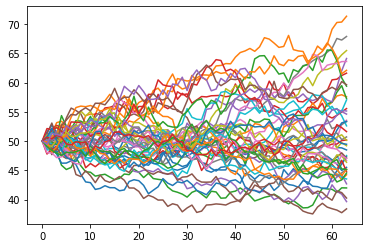

In [543]:
for i in range(45):
    plt.plot(gbm_price_sim[:, i])

Hedging Error Calculation

In [544]:
dV = option_prices[1:] - option_prices[0:(len(option_prices)-1)]
dS = gbm_price_sim[1:] - gbm_price_sim[0:(len(gbm_price_sim)-1)]
rdt = np.repeat(r*T/nparts, nsims)
Bt = option_prices - deltas*gbm_price_sim

In [545]:
dP = -1*dV + deltas[0:(len(deltas)-1)]*dS + Bt[0:(len(Bt)-1)] * rdt
H = dP.cumsum(axis=0)[-1] - np.maximum(np.repeat(0, nsims), gbm_price_sim[-1] - K)
H

array([-0.38364336, -0.26459849, -0.03163949, ...,  0.1844398 ,
        0.03614143,  0.1714143 ])

Hedging Error Function + Daily vs Weekly Rebalancing

In [546]:
def hedging_error(nsims, S0, sig, mu, T, K, discrete_freq, r):
    nparts = int(T)*discrete_freq + int(discrete_freq * (T - np.floor(T)))
    # GBM simulation
    gbm_price_sim = simulate_gbm_paths(nsims, S0, sig, mu, T, discrete_freq)
    # Option prices calculation
    option_prices = np.array([bs_call_pricer(gbm_price_sim[i], r, sig, T - i*T/nparts , K) for i in range(len(gbm_price_sim))])
    # Delta Calculations
    deltas = np.array([delta_wrt_time(gbm_price_sim[i], r, sig, T-i*T/nparts, K) for i in range(len(gbm_price_sim))])
    
    dV = option_prices[1:] - option_prices[0:(len(option_prices)-1)]
    dS = gbm_price_sim[1:] - gbm_price_sim[0:(len(gbm_price_sim)-1)]
    rdt = np.repeat(r*T/nparts, nsims)
    Bt = option_prices - deltas*gbm_price_sim

    dP = -1*dV + deltas[0:(len(deltas)-1)]*dS + Bt[0:(len(Bt)-1)] * rdt
    H = dP.cumsum(axis=0)[-1] - np.maximum(np.repeat(0, nsims), gbm_price_sim[-1] - K)
    return H

In [547]:
H_weekly = hedging_error(nsims, S0, sig, mu, T, K, 52, r)
H_daily =  hedging_error(nsims, S0, sig, mu, T, K, 252, r)

C:\Users\sidiy\AppData\Local\Temp/ipykernel_21300/1464969425.py:22: RuntimeWarning:

divide by zero encountered in double_scalars

C:\Users\sidiy\AppData\Local\Temp/ipykernel_21300/1464969425.py:27: RuntimeWarning:

divide by zero encountered in double_scalars



0.32989695654528417

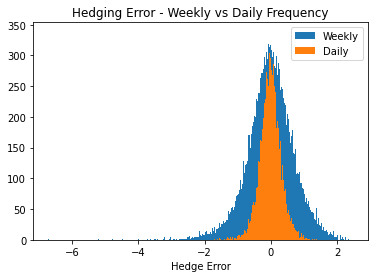

In [549]:
plt.title("Hedging Error - Weekly vs Daily Frequency")
plt.hist(H_weekly, bins=2000, label="Weekly")
plt.hist(H_daily, bins=2000, label = "Daily")
plt.xlabel("Hedge Error")
plt.legend()

np.std(H_daily)

From the chart, it's clear that the hedging error is centered around 0, and daily hedging has a tighter distribution around 0. Higher hedge frequency brings the error closer to 0. 

**(b) Take different values for $\mu$ (e.g., $\mu$ in the range 0 to 1). Does this impact the mean and standard deviation of the hedging error with daily and weekly rebalancing? Explain your findings.**

In [550]:
mu_arr = np.arange(start=0, stop=1, step=.05)
H_weekly_wrt_mu = np.array([hedging_error(nsims, S0, sig, i, T, K, 52, r) for i in mu_arr])
H_daily_wrt_mu = np.array([hedging_error(nsims, S0, sig, i, T, K, 252, r) for i in mu_arr])

H_weekly_avg_mu = np.average(H_weekly_wrt_mu, axis=1)
H_weekly_std_mu = np.std(H_weekly_wrt_mu, axis=1)

H_daily_avg_mu = np.average(H_daily_wrt_mu, axis=1)
H_daily_std_mu = np.std(H_daily_wrt_mu, axis=1)

C:\Users\sidiy\AppData\Local\Temp/ipykernel_21300/1464969425.py:22: RuntimeWarning:

divide by zero encountered in double_scalars

C:\Users\sidiy\AppData\Local\Temp/ipykernel_21300/1464969425.py:27: RuntimeWarning:

divide by zero encountered in double_scalars



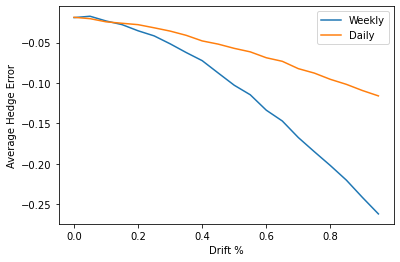

In [551]:
plt.plot(mu_arr, H_weekly_avg_mu, label="Weekly")
plt.plot(mu_arr, H_daily_avg_mu, label="Daily")
plt.xlabel("Drift %")
plt.ylabel("Average Hedge Error")
plt.legend()

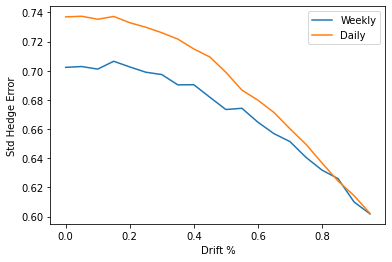

In [552]:
plt.plot(mu_arr, H_weekly_std_mu, label="Weekly")
plt.plot(mu_arr, np.sqrt(5)*H_daily_std_mu, label="Daily")
plt.xlabel("Drift %")
plt.ylabel("Std Hedge Error")
plt.legend()

It seems that as drift increases, weekly average hedge error increases (in magnitude) faster than daily average hedge error. This is obvious because there is more drift between each increment of $S_t$. Since the model's $\Delta_t$ is constant over the increment, the hedge error will increase. Of course the weekly error will be greater because the price increase in a week will be much larger than in a day. 

Also, as drift increases, daily std hedge error starts off higher but both decrease and converge. I cannot explain why daily std error would be greater than weekly std err, and I can't explain why both would decrease as drift increases. 

**(c) Let $\Delta_t$ denote the rebalancing interval. We know that as $\Delta t \rightarrow 0$ the hedging error goes to 0. What does your simulation suggest about the rate of convergence? Does the hedging error appear to be of order $(\Delta t)^{\alpha}$ for some $\alpha > 0$, and if so, what $\alpha$?**

In [553]:
discrete_freq_arr = np.arange(start=50, stop=500, step=50)
H_dt = np.array([hedging_error(nsims, S0, sig, mu, T, K, i, r) for i in discrete_freq_arr])

C:\Users\sidiy\AppData\Local\Temp/ipykernel_21300/1464969425.py:22: RuntimeWarning:

divide by zero encountered in double_scalars

C:\Users\sidiy\AppData\Local\Temp/ipykernel_21300/1464969425.py:27: RuntimeWarning:

divide by zero encountered in double_scalars



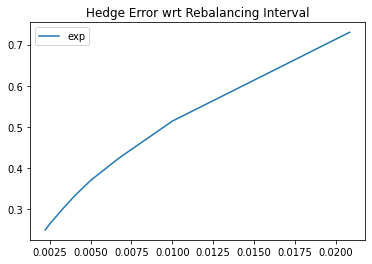

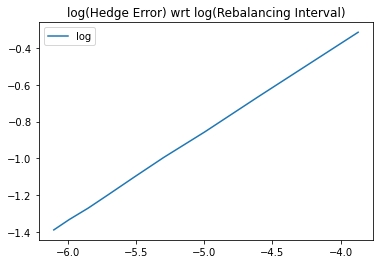

0.4814795670979288

In [554]:
dt = T / (int(T)*discrete_freq_arr + np.floor(discrete_freq_arr * (T - np.floor(T))))
H_std_dt = np.std(H_dt, axis=1)

plt.plot(dt, H_std_dt, label = "exp")
plt.title("Hedge Error wrt Rebalancing Interval")
plt.legend()
plt.show()

plt.plot(np.log(dt), np.log(H_std_dt), label = "log")
plt.title("log(Hedge Error) wrt log(Rebalancing Interval)")
plt.legend()
plt.show()

alpha, intercept, r_value, p_value, std_err = linregress(np.log(dt), np.log(H_std_dt))
alpha

In this case, $\alpha = .479 \approx 1/2$. We have $error \propto (\Delta t)^{1/2}$
<hr/>

## Problem 2

**Make a histogram of the distribution of hedging errors for both cases. How does the hedge perform? Does higher rebalancing frequency help? Explain your findings.**

Model Parameters

In [555]:
S0 = 50
sig = .3
K = 50
mu = .1
r = .05
T = .25
nsims = 100000
discrete_freq = 252
nparts = int(T)*discrete_freq + int(discrete_freq * (T - np.floor(T)))

Modified Pricing Tool + Modified Delta Calculation

In [556]:
# Had to redefine the pricing mechanism because I used a different approach that problem specified in Problem 1
def stop_start_pricer(S0_arr, r, tau, K):
    return np.maximum(S0_arr - K*np.exp(-r*tau), np.repeat(0, len(S0_arr)))

def delta_stop_start(S0_arr, r, tau, K):
    return (S0_arr > K*np.exp(-r*tau))*1

def hedging_error_stop_start(nsims, S0, sig, mu, T, K, discrete_freq, r):
    nparts = int(T)*discrete_freq + int(discrete_freq * (T - np.floor(T)))
    # GBM simulation
    gbm_price_sim = simulate_gbm_paths(nsims, S0, sig, mu, T, discrete_freq)
    # Option prices calculation
    option_prices = np.array([stop_start_pricer(gbm_price_sim[i], r, T - i*T/nparts , K) for i in range(len(gbm_price_sim))])
    # Delta Calculations
    deltas = np.array([delta_stop_start(gbm_price_sim[i], r, T-i*T/nparts, K) for i in range(len(gbm_price_sim))])

    dV = option_prices[1:] - option_prices[0:(len(option_prices)-1)]
    dS = gbm_price_sim[1:] - gbm_price_sim[0:(len(gbm_price_sim)-1)]
    rdt = np.repeat(r*T/nparts, nsims)
    Bt = option_prices - deltas*gbm_price_sim

    dP = -1*dV + deltas[0:(len(deltas)-1)]*dS + Bt[0:(len(Bt)-1)] * rdt
    H = dP.cumsum(axis=0)[-1] - np.maximum(np.repeat(0, nsims), gbm_price_sim[-1] - K)
    return H

In [557]:
H_weekly = hedging_error_stop_start(nsims, S0, sig, mu, T, K, 52, r)
H_daily =  hedging_error_stop_start(nsims, S0, sig, mu, T, K, 252, r)

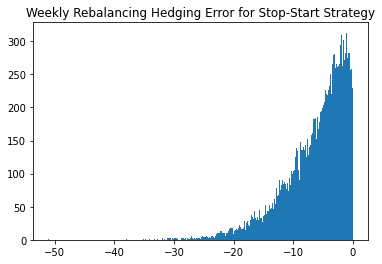

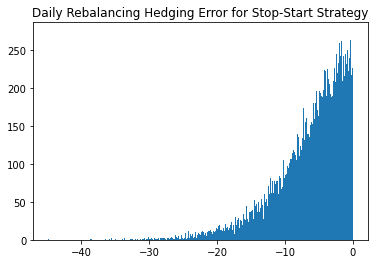

In [558]:
plt.hist(H_weekly, bins=2000)
plt.title("Weekly Rebalancing Hedging Error for Stop-Start Strategy")
plt.show()

plt.hist(H_daily, bins=2000)
plt.title("Daily Rebalancing Hedging Error for Stop-Start Strategy")
plt.show()

Clearly, this strategy is very bad we always underprices the option price relative to Black Scholes. There also doesn't seem to be a large difference between daily and weekly rebalancing.
<hr>

## Problem 3

**In this problem we consider what happens to the Black-Scholes hedging strategy if volatility is not constant.**

Model Parameters

In [559]:
S0 = 50
sig = .3
K = 50
mu = .1
beta = -.8
alpha = sig/np.power(S0, beta)
r = .05
T = .25
nsims = 100000
discrete_freq = 252
nparts = int(T)*discrete_freq + int(discrete_freq * (T - np.floor(T)))

In [560]:
# simulates GBM paths
def simulate_cev_paths(nsims, S0, alpha, beta, mu, T, discrete_freq):
    '''
    nsims: number of simulations to produce
    S0: initial stock price
    sig: volatility expressed as a percentage
    mu: annualized drift expressed as a percentage
    r: interest rate
    T: time in years
    discrete_freq: number of discrete time intervals per increment of T (252 would be 1 trading year)
    '''
    nparts = int(T)*discrete_freq + int(discrete_freq * (T - np.floor(T)))
    dt = T / nparts
    S0_arr = np.repeat(S0, nsims)
    Xt = [S0_arr]

    for i in range(1, nparts):
        Xt.append((1+mu*dt + alpha*np.power(Xt[i-1], beta)*np.sqrt(dt)*np.random.normal(size=(nsims)))* Xt[i-1])

    Xt = np.array(Xt)
    return Xt

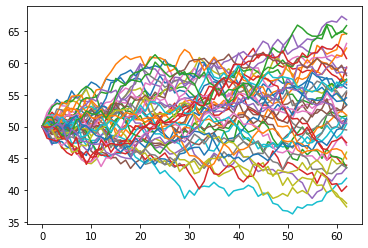

In [561]:
cev_price_paths = simulate_cev_paths(nsims, S0, alpha, beta, mu, T, discrete_freq)
for i in range(45):
    plt.plot(cev_price_paths[:, i])

In [562]:
def hedging_error_cev(nsims, S0, alpha, beta, mu, T, K, discrete_freq, r):
    nparts = int(T)*discrete_freq + int(discrete_freq * (T - np.floor(T)))
    # CEV simulation
    cev_price_sim = simulate_cev_paths(nsims, S0, alpha, beta, mu, T, discrete_freq)
    # Option prices calculation
    option_prices = np.array([bs_call_pricer(cev_price_sim[i], r, sig, T - i*T/nparts , K) for i in range(len(cev_price_sim))])
    # Delta Calculations
    deltas = np.array([delta_wrt_time(cev_price_sim[i], r, sig, T-i*T/nparts, K) for i in range(len(cev_price_sim))])
    
    dV = option_prices[1:] - option_prices[0:(len(option_prices)-1)]
    dS = cev_price_sim[1:] - cev_price_sim[0:(len(cev_price_sim)-1)]
    rdt = np.repeat(r*T/nparts, nsims)
    Bt = option_prices - deltas*cev_price_sim

    dP = -1*dV + deltas[0:(len(deltas)-1)]*dS + Bt[0:(len(Bt)-1)] * rdt
    H = dP.cumsum(axis=0)[-1] - np.maximum(np.repeat(0, nsims), cev_price_sim[-1] - K)
    return H

**(a) Same as Problem 1(a)**

In [563]:
H_weekly = hedging_error_cev(nsims, S0, alpha, beta, mu, T, K, 52, r)
H_daily =  hedging_error_cev(nsims, S0, alpha, beta, mu, T, K, 252, r)

0.3158030169016721

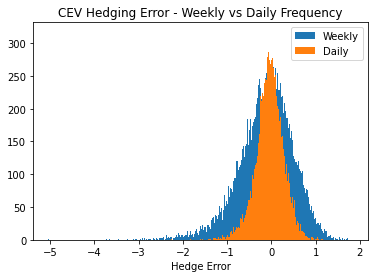

In [566]:
plt.title("CEV Hedging Error - Weekly vs Daily Frequency")
plt.hist(H_weekly, bins=2000, label="Weekly")
plt.hist(H_daily, bins=2000, label = "Daily")
plt.xlabel("Hedge Error")
plt.legend()

np.std(H_daily)

The charts between problem 1 and 3 are very similar. There is almost no difference between the two. 

**(c) Let $\Delta_t$ denote the rebalancing interval. We know that as $\Delta t \rightarrow 0$ the hedging error goes to 0. What does your simulation suggest about the rate of convergence? Does the hedging error appear to be of order $(\Delta t)^{\alpha}$ for some $\alpha > 0$, and if so, what $\alpha$?**

In [534]:
discrete_freq_arr = np.arange(start=50, stop=500, step=50)
H_dt = np.array([hedging_error_cev(nsims, S0, alpha, beta, mu, T, K, i, r) for i in discrete_freq_arr])

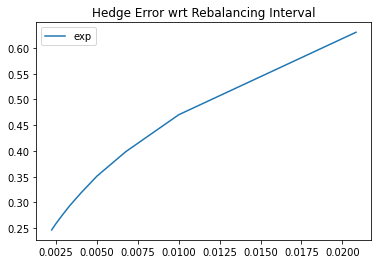

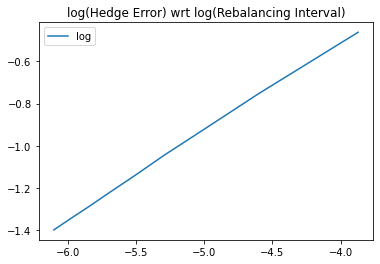

0.42244639499635445

In [535]:
dt = T / (int(T)*discrete_freq_arr + np.floor(discrete_freq_arr * (T - np.floor(T))))
H_std_dt = np.std(H_dt, axis=1)

plt.plot(dt, H_std_dt, label = "exp")
plt.title("Hedge Error wrt Rebalancing Interval")
plt.legend()
plt.show()

plt.plot(np.log(dt), np.log(H_std_dt), label = "log")
plt.title("log(Hedge Error) wrt log(Rebalancing Interval)")
plt.legend()
plt.show()

alpha, intercept, r_value, p_value, std_err = linregress(np.log(dt), np.log(H_std_dt))
alpha

In this case, $\alpha = .422 \approx 1/2$. We have $error \propto (\Delta t)^{1/2}$. Or perhaps the CEV process converges a bit faster than the GBM process. This seems very unnatural to me.
<hr/>

## Problem 4

**(a) Write a function that uses Cholesky decomposition to find a lower triangular matrix A such that $\Sigma = AA^T$. Demonstrate that your code works for d = 3 and $\rho$ = 0.1.**

In [600]:
# Cholesky-Banachiewicz algorithm
# Wikipedia: https://en.wikipedia.org/wiki/Cholesky_decomposition
def cholesky_decomposition(matrix):
    mat_copy = np.copy(matrix)
    n = mat_copy.shape[0]
    A = np.zeros(shape=(n,n))

    for i in range(n):
        for j in range(i+1):
            s = 0
            for k in range(j):
                s += A[i,k]*A[j,k]
            
            if i == j:
                A[i,j] = np.sqrt(mat_copy[i,i] - s)
            else:
                A[i,j] = (1/A[j,j] * (mat_copy[i,j] - s))
    return A

def create_corr_mat(n, p):
    return np.ones(shape=(n,n))*p + np.diag(np.repeat(1-p, n))

In [603]:
matrix = create_corr_mat(3, .1)
print("Matrix: \n", matrix)
L = cholesky_decomposition(matrix)
print("Cholesky Lower Triangular Matirx: \n", L)
print("Proof of Correctness: \n", np.matmul(L, L.T))

Matrix: 
 [[1.  0.1 0.1]
 [0.1 1.  0.1]
 [0.1 0.1 1. ]]
Cholesky Lower Triangular Matirx: 
 [[1.         0.         0.        ]
 [0.1        0.99498744 0.        ]
 [0.1        0.0904534  0.99086739]]
Proof of Correctness: 
 [[1.  0.1 0.1]
 [0.1 1.  0.1]
 [0.1 0.1 1. ]]


**(b) Use Monte Carlo simulation to price a European basket option**

Model Parameters

In [763]:
nsims = 100000
d = 3
S0 = 1
mu = 0
sig = .3
T = 1
K = 1
discrete_freq = 252
p = .8
corr_mat = create_corr_mat(d, p)

Create and Test Multivariate GBM

In [733]:
def simulate_multid_gbm(nsims, d, S0, mu, sig, corr_mat, T, discrete_freq):
    nparts = int(T)*discrete_freq + int(discrete_freq * (T - np.floor(T)))
    dt = T / nparts

    A = cholesky_decomposition(corr_mat)
    Z = np.random.normal(size=(nparts, d, nsims))
    mu_sig = np.array([np.array([(np.repeat(mu, nsims) - np.repeat(sig**2, nsims)/2)*dt]*d)]*nparts)

    Xt = np.exp(np.log(np.repeat(S0, nsims)) + np.cumsum(mu_sig + np.sqrt(dt)*np.matmul(A, Z.T).T, axis=0))
    return Xt

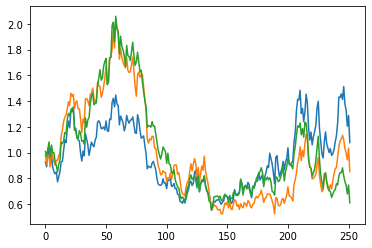

In [752]:
# MV GBM Simulation
# Syntax s[timestep, stock, sim]
mv_gbm_prices = simulate_multid_gbm(nsims, d, S0, mu, sig, create_corr_mat(d, p), T, discrete_freq)
plt.plot(mv_gbm_prices[:,:,0])

In [760]:
np.max(mv_gbm_prices[-1,:,0])

1.0776237329916853

Analyzing effect of $d$ and $p$ on option price

In [762]:
def max_basket_option_pricer(nsims, d, S0, mu, sig, T, K, discrete_freq, p):
    corr_mat = create_corr_mat(d, p)
    mv_gbm_prices = simulate_multid_gbm(nsims, d, S0, mu, sig, corr_mat, T, discrete_freq)

    payoffs = np.average([np.max(np.max(mv_gbm_prices[-1, :, i]) - K, 0) for i in range(nsims)])
    return np.exp(-r*T)*payoffs

In [771]:
d = 3
p_arr_3 = np.arange(-1/(d-1)+.001, 1, .2)
op_price_max_basket_d3_wrt_p = [max_basket_option_pricer(nsims, d, S0, mu, sig, T, K, discrete_freq, i) for i in p_arr_3]

d = 4
p_arr_4 = np.arange(-1/(d-1)+.001, 1, .2)
op_price_max_basket_d4_wrt_p = [max_basket_option_pricer(nsims, d, S0, mu, sig, T, K, discrete_freq, i) for i in p_arr_4]

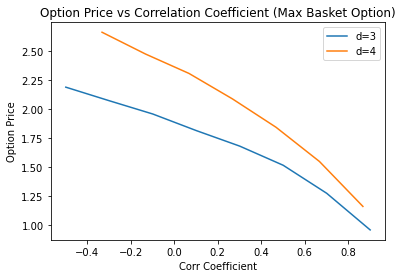

In [780]:
plt.plot(p_arr_3, op_price_max_basket_d3_wrt_p, label="d=3")
plt.plot(p_arr_4, op_price_max_basket_d4_wrt_p, label = "d=4")
plt.title("Option Price vs Correlation Coefficient (Max Basket Option)")
plt.xlabel("Corr Coefficient")
plt.ylabel("Option Price")
plt.legend()
plt.show()

As the number of stocks in the basket grow, the expected maximum will also be higher, which is reflected in this chart.

**(c) Repeat part (b) for a European basket option with average basket payoff**

In [778]:
def average_basket_option_pricer(nsims, d, S0, mu, sig, T, K, discrete_freq, p):
    corr_mat = create_corr_mat(d, p)
    mv_gbm_prices = simulate_multid_gbm(nsims, d, S0, mu, sig, corr_mat, T, discrete_freq)

    payoffs = np.average([np.max(np.average(mv_gbm_prices[-1, :, i]) - K, 0) for i in range(nsims)])
    return np.exp(-r*T)*payoffs

In [779]:
d = 3
p_arr_3 = np.arange(-1/(d-1)+.001, 1, .2)
op_price_avg_basket_d3_wrt_p = [average_basket_option_pricer(nsims, d, S0, mu, sig, T, K, discrete_freq, i) for i in p_arr_3]

d = 4
p_arr_4 = np.arange(-1/(d-1)+.001, 1, .2)
op_price_avg_basket_d4_wrt_p = [average_basket_option_pricer(nsims, d, S0, mu, sig, T, K, discrete_freq, i) for i in p_arr_4]

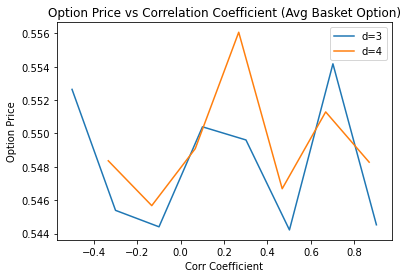

In [781]:
plt.plot(p_arr_3, op_price_avg_basket_d3_wrt_p, label="d=3")
plt.plot(p_arr_4, op_price_avg_basket_d4_wrt_p, label = "d=4")
plt.title("Option Price vs Correlation Coefficient (Avg Basket Option)")
plt.xlabel("Corr Coefficient")
plt.ylabel("Option Price")
plt.legend()
plt.show()

This is very interesting. d=4 option price is still higher than d=3 in most places despite using the average method for basket options. I cannot explain why this is the case, but perhaps outliers are more common in slightly larger baskets (very small thought). 

Another interesting characteristic is the option price has peaks and troughs relative to corr coefficient. This is very bizzare and I cannot explain this. 